# Превысит ли средний заработок человека порог 50000 долларов?

In [98]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", font_scale=1.2, rc={'axes.labelsize': 16, 'legend.fontsize': 14, 
                                              'grid.color': '.6', 'grid.linestyle': ':'})


from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from scipy.stats import norm as norm_distr

import warnings
warnings.filterwarnings('ignore')

## Содержание

0. Загрузка данных
1. Анализ данных
2. Категориальные признаки
3. Нормализация данных
4. Валидация
5. Выбор алгоритма и оптимизация
  * KNN
  * SGD Linear Classifier
  * RandomForestClassifier
6. Ансамбль моделей
7. Анализ качества моделей
8. Выводы

## Данные

In [139]:
# В данной таблице NaNы заполнены значком '?' - заменим его на пропуски с помощью параметра "na_values"
data_adult = pd.read_csv("data.csv", na_values='?')
data_adult.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K


#### Информация о данных:

1) age (Возраст): continuous. 

2) workclass (Информация о работе): Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 

3) fnlwgt (Вещественный признак - анонимен): continuous. 

4) education (Образование): Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 

5) education-num: continuous. 

6) marital-status (Семейное положение): Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 

7) occupation (Род деятельности): Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 

8) relationship (Статус в семье): Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 

9) race (Раса): White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black. 

10) sex (Пол): Female, Male. 

11) capital-gain (Размер капитала): continuous. 

12) capital-loss (Фича на основе капитала): continuous. 

13) hours-per-week (Сколько часов в неделю работает): continuous.

14) >50K,<=50K (таргет)

## 1. Анализ

В данных есть пропуски. Найдем признаки, где есть пропущенные значения. Также удалим из выборки все объекты с пропусками.
После этого посмотрим сколько данных останется.

In [100]:
'''
Посмотрим общую информацию о датафрейме (тип данных, количество непустых ячеек), 
видим, что есть пропуски в workclass, occupation, причем их почти по 1000. 
Если пропуски workclass и пропуски occupation в разных строках, то будет грустно (2000 от 16000 это уже больше 10%)
'''
data_adult.info()

# удаление строк, где есть хотя бы один пропуск
data_adult = data_adult.dropna()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16280 entries, 0 to 16279
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             16280 non-null  int64 
 1   workclass       15351 non-null  object
 2   fnlwgt          16280 non-null  int64 
 3   education       16280 non-null  object
 4   education-num   16280 non-null  int64 
 5   marital-status  16280 non-null  object
 6   occupation      15347 non-null  object
 7   relationship    16280 non-null  object
 8   race            16280 non-null  object
 9   sex             16280 non-null  object
 10  capital-gain    16280 non-null  int64 
 11  capital-loss    16280 non-null  int64 
 12  hours-per-week  16280 non-null  int64 
 13  >50K,<=50K      16280 non-null  object
dtypes: int64(6), object(8)
memory usage: 1.7+ MB


In [101]:
# проверим, что теперь нет пропущенных значений
'''
Как оказалось все пропуски workclass были в тех же строчках, где были пропуски в occupation (раз осталось 
15347 строк = число непустых значений occupation)
'''
data_adult.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15347 entries, 0 to 16279
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             15347 non-null  int64 
 1   workclass       15347 non-null  object
 2   fnlwgt          15347 non-null  int64 
 3   education       15347 non-null  object
 4   education-num   15347 non-null  int64 
 5   marital-status  15347 non-null  object
 6   occupation      15347 non-null  object
 7   relationship    15347 non-null  object
 8   race            15347 non-null  object
 9   sex             15347 non-null  object
 10  capital-gain    15347 non-null  int64 
 11  capital-loss    15347 non-null  int64 
 12  hours-per-week  15347 non-null  int64 
 13  >50K,<=50K      15347 non-null  object
dtypes: int64(6), object(8)
memory usage: 1.8+ MB


### Анализ таргета
- Выделим целевую переменную (таргет) в отдельную переменную ('target')
- Преобразуем target к бинарному формату ({0,1})
- Удалим из датасета старую переменную.
- Посмотрим распределение таргета

In [102]:
target = data_adult['>50K,<=50K']

# посмотрим, что имеются только 2 различных значения
print('Различные значения в target до преобразования к 0/1:', target.unique())
'''
Все в порядке - всего 2 различных значения (лишние не затесались)
'''

# преобразуем к бинарному формату ('>50k' => 1, '<=50k' => 0)
target = target.map({'<=50K': 0, '>50K': 1})

# удаление из датасета столбца
data_adult.drop('>50K,<=50K', axis=1, inplace=True)
# data_adult.head()

# распределение целевой переменной
print('-'*75)
print('распределение целевой переменной')
print(target.value_counts())

# Нет баланса классов (почти в 3 раза больше меток типа "0")

Различные значения в target до преобразования к 0/1: ['<=50K' '>50K']
---------------------------------------------------------------------------
распределение целевой переменной
0    11407
1     3940
Name: >50K,<=50K, dtype: int64


- Посмотрим процентное соотношение категорий в колонке "workclass"

In [103]:
print('-'*50)
print('Процентное соотношение категорий в колонке "workclass"')
print('-'*50)
print(data_adult['workclass'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%')

--------------------------------------------------
Процентное соотношение категорий в колонке "workclass"
--------------------------------------------------
Private             73.51%
Self-emp-not-inc     8.63%
Local-gov            6.95%
State-gov             4.2%
Self-emp-inc         3.66%
Federal-gov           3.0%
Without-pay          0.05%
Name: workclass, dtype: object


### 2. Категориальные признаки

При анализе признаков были обнаружены категориальные среди них.

- Выделим 2 переменные (cat - список категориальных признаков, num - список вещественных признаков);
- Закодируем категориальные признаки;
- Выберем признаки для обучения.

In [104]:
# типы данных каждой категории
types_of_feat = data_adult.dtypes

# скорее всего категориальные признаки - где тип данных object
potential_cat_feat = types_of_feat[types_of_feat == 'object'].index.to_list()
quant_feat = types_of_feat[types_of_feat == 'int64'].index.to_list()

In [105]:
# исследуем сначала каждый потенциальный категориальный признак: посмотрим сколько различных элементов, и какие они
# затем посмотрим основные статистики количественных признаков

def get_cat_info(feat_name):
    '''
    input: название категориального признака (тип: str)
    return: количество уникальных элементов и список названий уникальных элементов
    '''
    
    print(f'информация о признаке \033[1m{feat_name}\033[0m')
    print('число уникальных элементов:', data_adult[feat_name].nunique(), 
          '\nназвания уникальных элементов:', data_adult[feat_name].unique())
    print('*'*75)

def get_quant_info(feat_name):
    '''
    input: название количественного признака (тип: str)
    return: основные статистики количественного признака
    '''
    print(f'информация о признаке \033[1m{feat_name}\033[0m')
    print(data_adult[feat_name].describe())
    print('*'*75)      
    
# категориальные признаки  
for feat in potential_cat_feat:
    get_cat_info(feat) 

print('\n\n')    
for feat in quant_feat:
    get_quant_info(feat)    

информация о признаке workclass
число уникальных элементов: 7 
названия уникальных элементов: ['Local-gov' 'Private' 'Federal-gov' 'Self-emp-inc' 'State-gov'
 'Self-emp-not-inc' 'Without-pay']
***************************************************************************
информация о признаке education
число уникальных элементов: 16 
названия уникальных элементов: ['HS-grad' 'Some-college' 'Bachelors' 'Assoc-acdm' '12th' 'Doctorate'
 '1st-4th' '7th-8th' 'Masters' '5th-6th' '11th' '9th' 'Assoc-voc'
 'Prof-school' '10th' 'Preschool']
***************************************************************************
информация о признаке marital-status
число уникальных элементов: 7 
названия уникальных элементов: ['Never-married' 'Divorced' 'Married-civ-spouse' 'Separated'
 'Married-spouse-absent' 'Married-AF-spouse' 'Widowed']
***************************************************************************
информация о признаке occupation
число уникальных элементов: 14 
названия уникальных элементов: [

In [106]:
# все potential_cat_feat - категориальные признаки => занесем названия признаков в cat
cat = types_of_feat[types_of_feat == 'object'].index.to_list()

# вещественные признаки - те, тип данных которых целочисленный или вещественный (в данном случае int64)
num = types_of_feat[types_of_feat == 'int64'].index.to_list()  

In [107]:
# кодируем категориальные признаки
data_adult = pd.get_dummies(data_adult, columns=cat)
data_adult.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male
0,34,284843,9,594,0,60,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
1,40,190290,10,0,0,40,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1
2,36,177858,13,0,0,40,0,1,0,0,...,1,0,0,0,0,0,0,1,0,1
3,22,184756,10,0,0,30,0,0,1,0,...,1,0,0,0,0,0,0,1,1,0
4,47,149700,13,15024,0,40,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1


In [108]:
# '''с помощью библиотеки feature-selector исследовал корреляции между признаками'''
# !pip install git+https://github.com/WillKoehrsen/feature-selector.git
# from feature_selector import FeatureSelector

# fs = FeatureSelector(data = data_adult, labels = data_adult.columns)
# PAIR_CORRELATION_MAX = 0.7

# '''фичи, парная корреляция между которыми очень сильная'''
# #correlation_threshold - порог, выше которого парная корреляция считается большой
# fs.identify_collinear(correlation_threshold = PAIR_CORRELATION_MAX)
# fs.record_collinear

В результате анализа парных корреляций было обнаружено, что только в трех случаях парная корреляция была больше, чем 0.7 (такой порог выставил):

relationship_Husband -- marital-status_Married-civ-spouse: corr_value = 0.891162

race_White	-- race_Black:	corr_value = -0.787711

sex_Male  --	sex_Female:	corr_value = -1.0

Корреляция между sex_Male и	sex_Female очевидна => нужно убрать один из этих признаков. По-хорошему, нужно убрать по признаку из оставшихся двух пар, но решил, что не буду.

In [109]:
train_columns = data_adult.columns.difference(['sex_Male'])

### 3. Нормализация данных

- Проведем анализ шкал признаков (какого порядка вещественные признаки?)

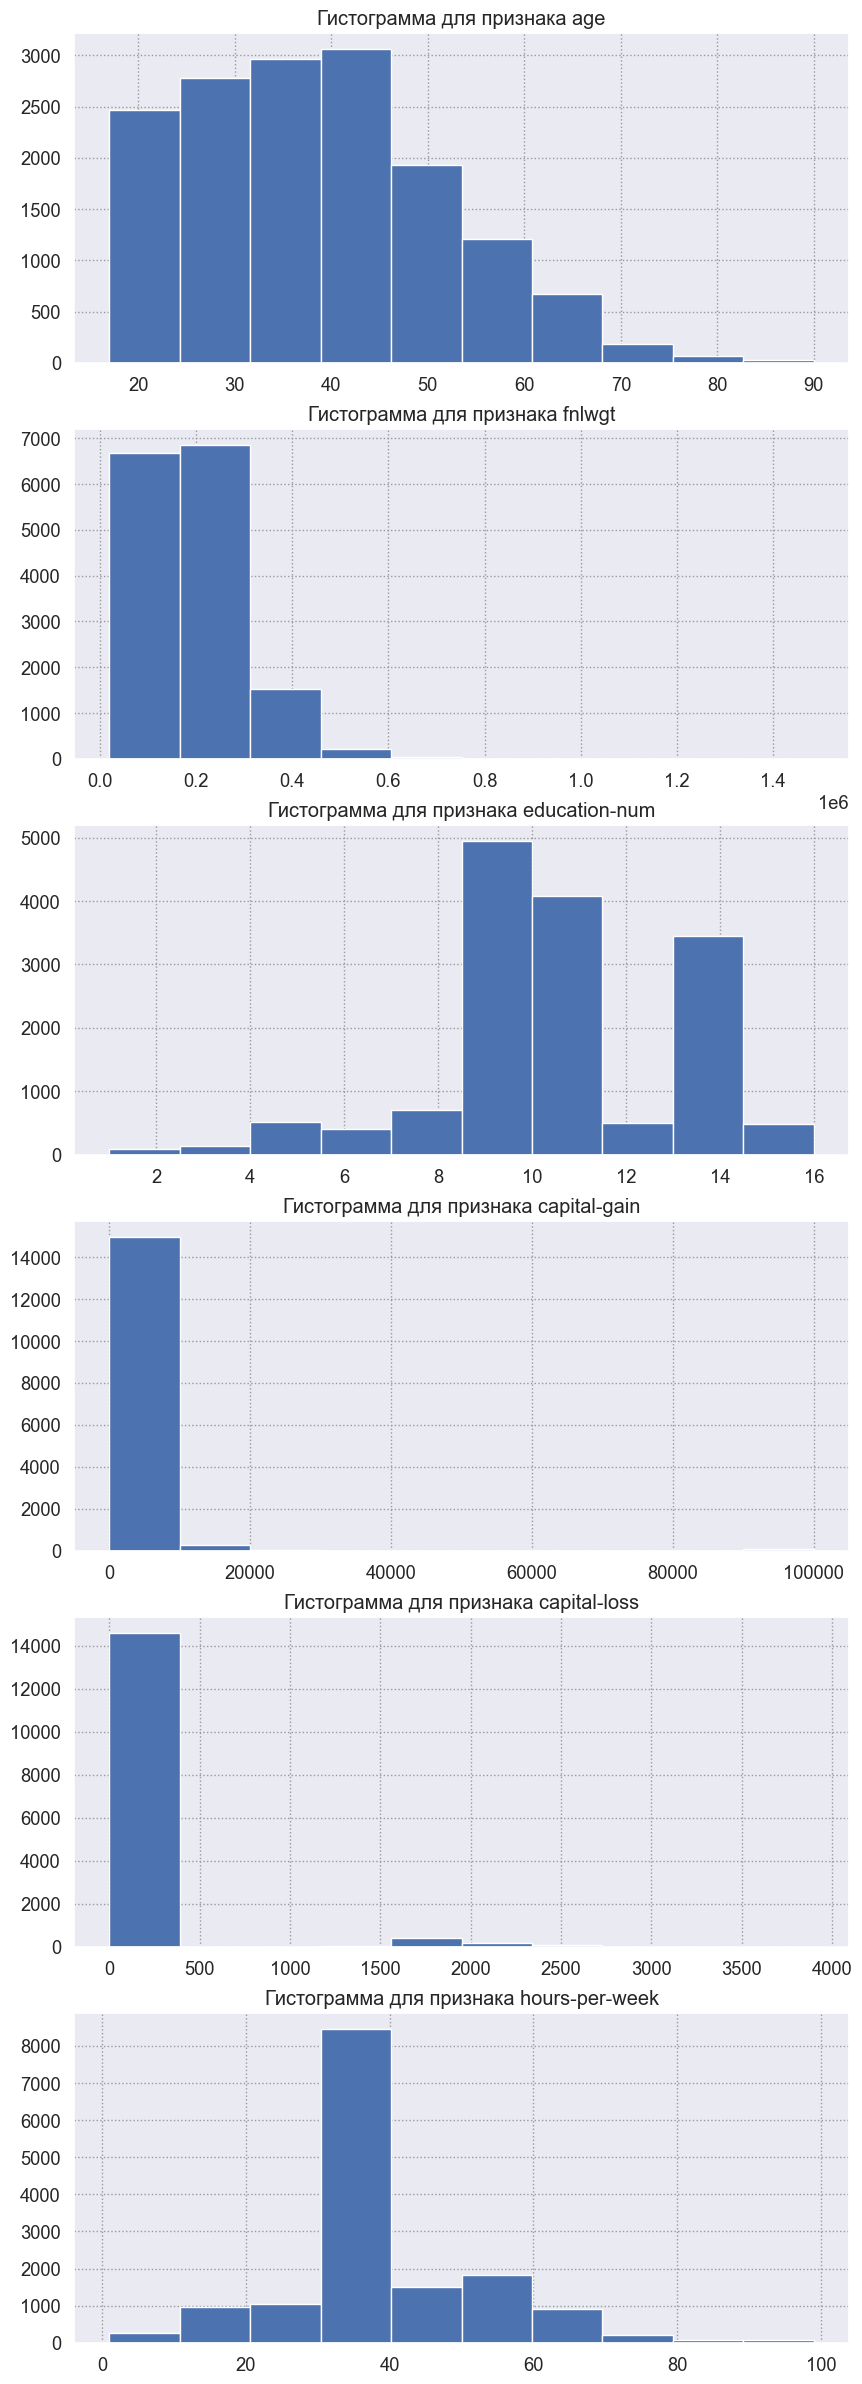

In [110]:
# гистограммы
fig, axes = plt.subplots(len(num),1, figsize = (10, 5*len(num)))
for i, feature in enumerate(num):
    axes[i].hist(data_adult[feature])
    axes[i].set_title(f'Гистограмма для признака {feature}')
plt.show()

In [111]:
#уже смотрел различные статистики вещественных признаков, но тут еще раз повторю
for feature in num:
    get_quant_info(feature)

информация о признаке age
count    15347.000000
mean        38.495537
std         13.110063
min         17.000000
25%         28.000000
50%         37.000000
75%         47.000000
max         90.000000
Name: age, dtype: float64
***************************************************************************
информация о признаке fnlwgt
count    1.534700e+04
mean     1.891545e+05
std      1.062935e+05
min      1.930200e+04
25%      1.168125e+05
50%      1.779370e+05
75%      2.368550e+05
max      1.484705e+06
Name: fnlwgt, dtype: float64
***************************************************************************
информация о признаке education-num
count    15347.000000
mean        10.150844
std          2.553045
min          1.000000
25%          9.000000
50%         10.000000
75%         13.000000
max         16.000000
Name: education-num, dtype: float64
***************************************************************************
информация о признаке capital-gain
count    15347.000000
mean 

- Анализ:
Видно, что вещественные признаки имеют различные порядки значений для средних, дисперсий и других характеристик. Например, среднее значение признака education-num около 10, а среднее значение признака fnlwgt порядка 10^5 (весьма сильные различия).


- Разница в масштабах различных признаков в ML может привести к нескольким проблемам, в том числе:

1. В модели будут доминировать признаки с более высокими масштабами, что приведет к смещенным результатам.
2. Для сходимости модели может потребоваться больше времени, особенно если в ней используются итерационные методы.
3. Некоторые алгоритмы могут стать нестабильными или плохо работать.
4. Без единого масштаба трудно сравнивать регрессионные коэффициенты при предикторах между собой.

- На какие алгоритмы машинного обучения может повлиять данная проблема и почему?

Алгоритмы машинного обучения, на которые влияет эта проблема, — это те, которые полагаются на меры расстояния между точками данных или те, которые используют оптимизацию градиентного спуска. В качестве примера можно привести следующие алгоритмы: линейная регрессия, логистическая регрессия, метод опорных векторов (SVM), нейронные сети и др.

- На какие алгоритмы машинного обучения не влияет масштабирование данных?

Алгоритмы машинного обучения, которые не зависят от масштабирования данных, включают в себя:
1. Деревья решений
2. Случайный лес 
3. Некоторые модели на основе градиентного бустинга (например, CatBoost)

Эти алгоритмы не требуют масштабирования, поскольку они не используют расстояния или различия масштабов при вычислениях. Однако, масштабирование данных может все же улучшить производительность этих алгоритмов.


### Финальная подготовка данных
- Отмасштабируем данные
- Выделим отдельно X (признаки) и y - target

In [112]:
scaler = StandardScaler()
scaler = scaler.fit(data_adult[num]) # вычисление средних и стандартных отклонений

data_adult[num] = scaler.transform(data_adult[num]) # произведение трансформации (вычитание среднего и деление на станд. откл.)

X = data_adult[train_columns]  # Признаки
y = target                     # таргет

Далее используйте масштабированные признаки

## 4. Валидация

Валидацию провожу с помощью StratifiedKFold из sklearn.model_selection (KFold + сохранение баланса классов в каждом "фолде")

In [113]:
NUM_SPLITS=5

# инициализируем кросс-валидатор
skf = StratifiedKFold(n_splits = NUM_SPLITS, shuffle = True, random_state = 0)

#### Обоснование выбора способа валидации

1. Виды валидации:
 - Hold-out валидация: данные разбиваются на обучающую и тестовую выборки (train-test split);
 - K-fold валидация: данные разбиваются на k блоков. Затем k раз проводится обучение модели на k-1 блоках и проверка на оставшемся блоке. Результаты каждого тестирования усредняются для получения итоговой оценки точности модели.
 - Leave-One-Out валидация (частный случай метода k-Fold: в нём каждый фолд состоит ровно из одного семпла)
 - Stratified K-fold валидация: это вариант K-fold валидации, в котором блоки формируются таким образом, чтобы сохранять соотношение классов в каждом блоке.
 
2. Плюсы и минусы подходов к валидации:
  - Hold-out:
    - Плюсы: простота реализации, быстрое время обучения;
    - Минусы: малая точность, потеря части данных, возможность переобучения.
  - K-fold:
    - Плюсы: более точная оценка производительности модели, использование всех доступных данных для обучения и тестирования;
    - Минусы: большее время обучения, сложность реализации.
  - Leave-One-Out:
    - Плюсы: наиболее точная оценка производительности модели, использование всех доступных данных для обучения и тестирования;
    - Минусы: очень большое время обучения; может привести к переобучению, если данные имеют много выбросов или нетипичных значений.
  - Stratified K-fold:
    - Плюсы: учитывает соотношение классов в данных, что может привести к более точной оценке;
    - Минусы: может быть вычислительно затратным для больших объемов данных; не подходит для данных, которые не имеют явного разделения на классы.

3. Преимущество StratifiedKFold над KFold:

StratifiedKFold является улучшенной версией KFold, которая сохраняет пропорции классов в каждом блоке. Это особенно важно, когда данных мало или когда классы не сбалансированы. Если разбиение будет случайным, то может оказаться так, что один из фолдов не будет содержать представителей определенного класса, что приведет к ошибкам при оценке модели. StratifiedKFold же гарантирует, что в фолдах будет примерно одинаковое процентное соотношение между представителями каждого класса, что позволяет получить более точные оценки модели.

Таким образом, в данной задаче целесообразно использовать StratifiedKFold.



## 5. Выбор алгоритма и оптимизация

При подборе алгоритма будем варьировать не один параметр, а несколько в каждом алгоритме.

Выберем 3 алгоритма:

 - kNN (подробнее [здесь](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html))
 - SGD Linear Classifier (подробнее [здесь](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html))
 - RandomForest (подробнее [здесь](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html))
 

## 5.1 kNN

- Инициализируем дефолтную модель.
- Инициализируем GridSearchCV для подбора гиперпараметров (подробнее [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)).
- Подберем наилучшие параметры для модели с помощью GridSearchCV.
- Построим график зависимости качества ROC_AUC от параметров (получается 2 графика) с доверительным интервалом. Ось Х - значения параметра, ось Y - значения ROC_AUC.

Подберем оптимальные параметры:
- Число соседей (**n_neighbors**). Перебор попробуем в диапазоне от 0 до 50 с шагом 2.
- Метрика (**metric**). Перебираем из \['minkowski', 'euclidean', 'chebyshev', 'manhattan'\].

Сохраним модель с оптимальными гиперпараметрами.

In [114]:
knn_model = KNeighborsClassifier(n_jobs=-1)

# посмотрим какие параметры стоят по умолчанию
print('гиперпараметры по умолчанию:\n', knn_model.get_params())

# пространство гиперпараметров
knn_parameters={'n_neighbors': range(0, 50, 2), 'metric':  ['minkowski', 'euclidean', 'chebyshev', 'manhattan']}

gridSearchCV_knn_clf = GridSearchCV(estimator=knn_model, param_grid=knn_parameters, cv=skf, scoring='roc_auc', verbose=3) 
# здесь skf - stratifiedKFolds кросс-валидатор с 5 фолдами (ранее был инициализирован)

гиперпараметры по умолчанию:
 {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': -1, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}


In [115]:
'''
По идее надо бы разделить данные на train и test, а затем уже train делить на непосредственно train и val 
(с помощью StratifiedKFolds), но решил не делать этого
'''
gridSearchCV_knn_clf.fit(X, y) # обучение

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END .....metric=minkowski, n_neighbors=0;, score=nan total time=   0.0s
[CV 2/5] END .....metric=minkowski, n_neighbors=0;, score=nan total time=   0.0s
[CV 3/5] END .....metric=minkowski, n_neighbors=0;, score=nan total time=   0.0s
[CV 4/5] END .....metric=minkowski, n_neighbors=0;, score=nan total time=   0.0s
[CV 5/5] END .....metric=minkowski, n_neighbors=0;, score=nan total time=   0.0s
[CV 1/5] END ...metric=minkowski, n_neighbors=2;, score=0.800 total time=   0.0s
[CV 2/5] END ...metric=minkowski, n_neighbors=2;, score=0.804 total time=   0.0s
[CV 3/5] END ...metric=minkowski, n_neighbors=2;, score=0.789 total time=   0.0s
[CV 4/5] END ...metric=minkowski, n_neighbors=2;, score=0.812 total time=   0.0s
[CV 5/5] END ...metric=minkowski, n_neighbors=2;, score=0.784 total time=   0.0s
[CV 1/5] END ...metric=minkowski, n_neighbors=4;, score=0.849 total time=   0.0s
[CV 2/5] END ...metric=minkowski, n_neighbors=

[CV 2/5] END ..metric=minkowski, n_neighbors=40;, score=0.888 total time=   0.1s
[CV 3/5] END ..metric=minkowski, n_neighbors=40;, score=0.891 total time=   0.0s
[CV 4/5] END ..metric=minkowski, n_neighbors=40;, score=0.900 total time=   0.0s
[CV 5/5] END ..metric=minkowski, n_neighbors=40;, score=0.883 total time=   0.0s
[CV 1/5] END ..metric=minkowski, n_neighbors=42;, score=0.896 total time=   0.0s
[CV 2/5] END ..metric=minkowski, n_neighbors=42;, score=0.888 total time=   0.0s
[CV 3/5] END ..metric=minkowski, n_neighbors=42;, score=0.892 total time=   0.0s
[CV 4/5] END ..metric=minkowski, n_neighbors=42;, score=0.900 total time=   0.0s
[CV 5/5] END ..metric=minkowski, n_neighbors=42;, score=0.883 total time=   0.1s
[CV 1/5] END ..metric=minkowski, n_neighbors=44;, score=0.896 total time=   0.0s
[CV 2/5] END ..metric=minkowski, n_neighbors=44;, score=0.889 total time=   0.0s
[CV 3/5] END ..metric=minkowski, n_neighbors=44;, score=0.892 total time=   0.0s
[CV 4/5] END ..metric=minkow

[CV 4/5] END ..metric=euclidean, n_neighbors=30;, score=0.898 total time=   0.0s
[CV 5/5] END ..metric=euclidean, n_neighbors=30;, score=0.882 total time=   0.0s
[CV 1/5] END ..metric=euclidean, n_neighbors=32;, score=0.896 total time=   0.0s
[CV 2/5] END ..metric=euclidean, n_neighbors=32;, score=0.887 total time=   0.0s
[CV 3/5] END ..metric=euclidean, n_neighbors=32;, score=0.890 total time=   0.0s
[CV 4/5] END ..metric=euclidean, n_neighbors=32;, score=0.899 total time=   0.0s
[CV 5/5] END ..metric=euclidean, n_neighbors=32;, score=0.882 total time=   0.0s
[CV 1/5] END ..metric=euclidean, n_neighbors=34;, score=0.896 total time=   0.0s
[CV 2/5] END ..metric=euclidean, n_neighbors=34;, score=0.888 total time=   0.0s
[CV 3/5] END ..metric=euclidean, n_neighbors=34;, score=0.890 total time=   0.0s
[CV 4/5] END ..metric=euclidean, n_neighbors=34;, score=0.899 total time=   0.0s
[CV 5/5] END ..metric=euclidean, n_neighbors=34;, score=0.883 total time=   0.0s
[CV 1/5] END ..metric=euclid

[CV 1/5] END ..metric=chebyshev, n_neighbors=22;, score=0.845 total time=   0.6s
[CV 2/5] END ..metric=chebyshev, n_neighbors=22;, score=0.842 total time=   0.5s
[CV 3/5] END ..metric=chebyshev, n_neighbors=22;, score=0.848 total time=   0.6s
[CV 4/5] END ..metric=chebyshev, n_neighbors=22;, score=0.855 total time=   0.6s
[CV 5/5] END ..metric=chebyshev, n_neighbors=22;, score=0.840 total time=   0.5s
[CV 1/5] END ..metric=chebyshev, n_neighbors=24;, score=0.844 total time=   0.6s
[CV 2/5] END ..metric=chebyshev, n_neighbors=24;, score=0.839 total time=   0.5s
[CV 3/5] END ..metric=chebyshev, n_neighbors=24;, score=0.846 total time=   0.6s
[CV 4/5] END ..metric=chebyshev, n_neighbors=24;, score=0.856 total time=   0.6s
[CV 5/5] END ..metric=chebyshev, n_neighbors=24;, score=0.838 total time=   0.6s
[CV 1/5] END ..metric=chebyshev, n_neighbors=26;, score=0.844 total time=   0.6s
[CV 2/5] END ..metric=chebyshev, n_neighbors=26;, score=0.839 total time=   0.6s
[CV 3/5] END ..metric=chebys

[CV 3/5] END ..metric=manhattan, n_neighbors=12;, score=0.874 total time=   0.4s
[CV 4/5] END ..metric=manhattan, n_neighbors=12;, score=0.893 total time=   0.3s
[CV 5/5] END ..metric=manhattan, n_neighbors=12;, score=0.869 total time=   0.4s
[CV 1/5] END ..metric=manhattan, n_neighbors=14;, score=0.887 total time=   0.4s
[CV 2/5] END ..metric=manhattan, n_neighbors=14;, score=0.879 total time=   0.4s
[CV 3/5] END ..metric=manhattan, n_neighbors=14;, score=0.876 total time=   0.3s
[CV 4/5] END ..metric=manhattan, n_neighbors=14;, score=0.893 total time=   0.3s
[CV 5/5] END ..metric=manhattan, n_neighbors=14;, score=0.873 total time=   0.4s
[CV 1/5] END ..metric=manhattan, n_neighbors=16;, score=0.888 total time=   0.3s
[CV 2/5] END ..metric=manhattan, n_neighbors=16;, score=0.879 total time=   0.4s
[CV 3/5] END ..metric=manhattan, n_neighbors=16;, score=0.877 total time=   0.3s
[CV 4/5] END ..metric=manhattan, n_neighbors=16;, score=0.895 total time=   0.4s
[CV 5/5] END ..metric=manhat

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=KNeighborsClassifier(n_jobs=-1),
             param_grid={'metric': ['minkowski', 'euclidean', 'chebyshev',
                                    'manhattan'],
                         'n_neighbors': range(0, 50, 2)},
             scoring='roc_auc', verbose=3)

In [116]:
# все результаты обучения модели
all_results_knn = gridSearchCV_knn_clf.cv_results_

'''
занесем в таблицу results_knn результаты обучения модели: среднее значение roc_auc, границы для 95%-ного доверительного
интервала и значения гиперпараметров
'''
results_knn = pd.DataFrame()
results_knn['mean_auc_score'] = all_results_knn['mean_test_score']      # среднее значение roc_auc_score


# значения гиперпараметров
results_knn['params'] = all_results_knn['params']
results_knn['metric'] = results_knn['params'].apply(lambda x: x.get('metric'))
results_knn['n_neighbors'] = results_knn['params'].apply(lambda x: x.get('n_neighbors'))
results_knn.drop(['params'], axis=1, inplace=True)
results_knn.sort_values('mean_auc_score', ascending=False).head()

,mean_auc_score,metric,n_neighbors
48,0.892139,euclidean,46
23,0.892139,minkowski,46
47,0.892095,euclidean,44
22,0.892095,minkowski,44
49,0.892054,euclidean,48


### Графики

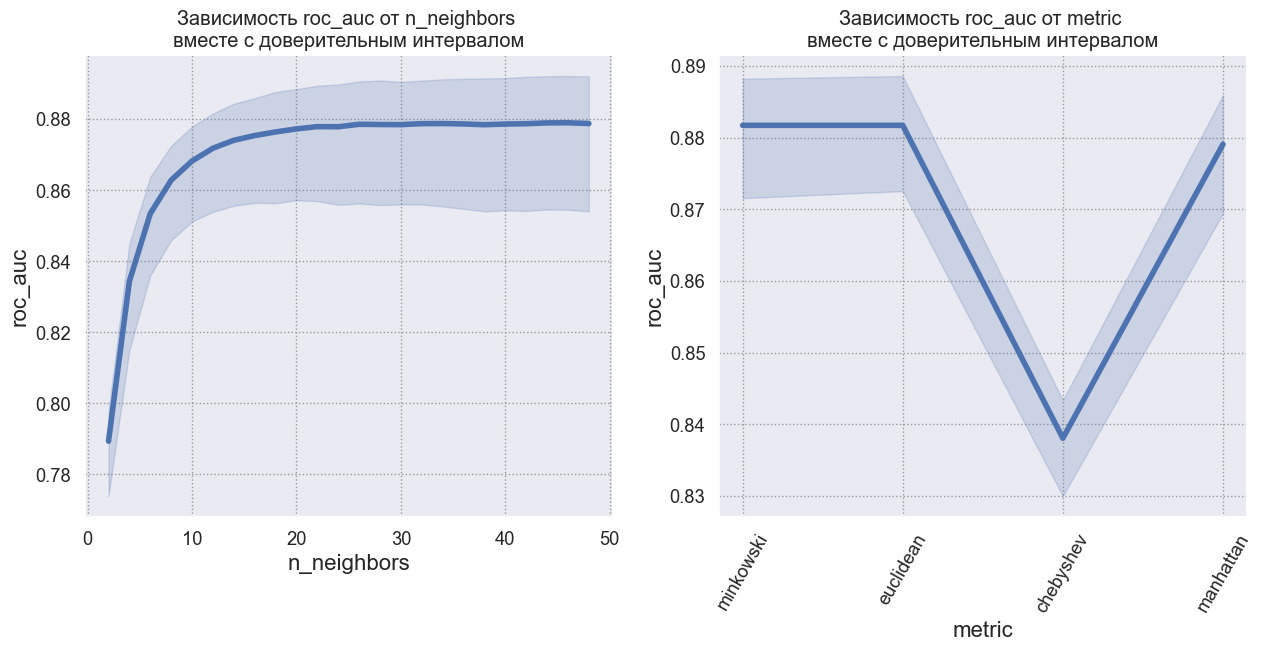

In [117]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 6))

'''
построение графика roc_auc от n_neighbors
'''
# построение графиков вместе с 95%-ными доверительными интервалами
sns.lineplot(ax=ax1, data=results_knn, x="n_neighbors", y="mean_auc_score", linewidth=4)
ax1.set(xlabel='n_neighbors', ylabel='roc_auc', 
            title='Зависимость roc_auc от n_neighbors \nвместе с доверительным интервалом')    

'''
построение графика roc_auc от metric
'''
sns.lineplot(ax=ax2, data=results_knn, x="metric", y="mean_auc_score", linewidth=4)
ax2.set(xlabel='metric', ylabel='roc_auc', 
            title='Зависимость roc_auc от metric \nвместе с доверительным интервалом')    
#поворот подписей
ax2.set_xticks(range(len(knn_parameters['metric'])))
ax2.set_xticklabels(knn_parameters['metric'], rotation=60)

plt.show()

Видим, что поначалу с ростом числа соседей качество модели улучшается, однако начиная с n_neighbors = 40 прогресс останавливается. Что касается метрики, то качество модели практически не изменяется при переключении метрики, кроме случая chebyshev metric - в этом случае качество модели значительно хуже.

In [118]:
# оптимальные гиперпараметры
print('Оптимальные гиперпараметры:',gridSearchCV_knn_clf.best_params_)

# возвращает классификатор с лучшими параметрами
best_gridSearchCV_knn_clf=gridSearchCV_knn_clf.best_estimator_  

Оптимальные гиперпараметры: {'metric': 'minkowski', 'n_neighbors': 46}


### 5.2 SGD Linear Classifier

- Инициализируем дефолтную модель.
- Инициализируем GridSearchCV для подбора гиперпараметров.
- Подберем наилучшие параметры для модели с помощью GridSearchCV.
- Построим график зависимости качества ROC_AUC от параметров (получается 2 графика) с доверительным интервалом. Ось Х - значения параметра, ось Y - значения ROC_AUC.

Подберем оптимальные параметры:
- Loss функция (**loss**). Перебирать буду из \['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_loss', 'huber', 'epsilon_insensitive'\]
- Вид штрафа (**penalty**). Перебор из \['none', 'l2', 'l1', 'elasticnet'\].

Сохраним модель с оптимальными гиперпараметрами.

In [119]:
sgd_model = SGDClassifier(n_jobs=-1)

# посмотрим какие параметры стоят по умолчанию
print('гиперпараметры по умолчанию:\n', sgd_model.get_params())

# пространство гиперпараметров
sgd_parameters={'loss':  ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'huber', 
                          'epsilon_insensitive'], 'penalty':  [None, 'l2', 'l1', 'elasticnet']}

gridSearchCV_sgd_clf = GridSearchCV(estimator=sgd_model, param_grid=sgd_parameters, cv=skf, scoring='roc_auc', verbose=3) 
# здесь skf - stratifiedKFolds кросс-валидатор с 5 фолдами (ранее был инициализирован)

гиперпараметры по умолчанию:
 {'alpha': 0.0001, 'average': False, 'class_weight': None, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'hinge', 'max_iter': 1000, 'n_iter_no_change': 5, 'n_jobs': -1, 'penalty': 'l2', 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


In [120]:
gridSearchCV_sgd_clf.fit(X, y) # обучение

Fitting 5 folds for each of 28 candidates, totalling 140 fits
[CV 1/5] END ..........loss=hinge, penalty=None;, score=0.902 total time=   0.0s
[CV 2/5] END ..........loss=hinge, penalty=None;, score=0.896 total time=   0.0s
[CV 3/5] END ..........loss=hinge, penalty=None;, score=0.899 total time=   0.0s
[CV 4/5] END ..........loss=hinge, penalty=None;, score=0.906 total time=   0.0s
[CV 5/5] END ..........loss=hinge, penalty=None;, score=0.891 total time=   0.0s
[CV 1/5] END ............loss=hinge, penalty=l2;, score=0.904 total time=   0.0s
[CV 2/5] END ............loss=hinge, penalty=l2;, score=0.892 total time=   0.1s
[CV 3/5] END ............loss=hinge, penalty=l2;, score=0.898 total time=   0.0s
[CV 4/5] END ............loss=hinge, penalty=l2;, score=0.907 total time=   0.0s
[CV 5/5] END ............loss=hinge, penalty=l2;, score=0.889 total time=   0.1s
[CV 1/5] END ............loss=hinge, penalty=l1;, score=0.905 total time=   0.1s
[CV 2/5] END ............loss=hinge, penalty=l1

[CV 1/5] END ..........loss=huber, penalty=None;, score=0.841 total time=   0.0s
[CV 2/5] END ..........loss=huber, penalty=None;, score=0.857 total time=   0.0s
[CV 3/5] END ..........loss=huber, penalty=None;, score=0.832 total time=   0.0s
[CV 4/5] END ..........loss=huber, penalty=None;, score=0.808 total time=   0.0s
[CV 5/5] END ..........loss=huber, penalty=None;, score=0.835 total time=   0.0s
[CV 1/5] END ............loss=huber, penalty=l2;, score=0.833 total time=   0.0s
[CV 2/5] END ............loss=huber, penalty=l2;, score=0.840 total time=   0.0s
[CV 3/5] END ............loss=huber, penalty=l2;, score=0.841 total time=   0.0s
[CV 4/5] END ............loss=huber, penalty=l2;, score=0.858 total time=   0.0s
[CV 5/5] END ............loss=huber, penalty=l2;, score=0.827 total time=   0.0s
[CV 1/5] END ............loss=huber, penalty=l1;, score=0.829 total time=   0.0s
[CV 2/5] END ............loss=huber, penalty=l1;, score=0.786 total time=   0.0s
[CV 3/5] END ............los

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=SGDClassifier(n_jobs=-1),
             param_grid={'loss': ['hinge', 'log_loss', 'modified_huber',
                                  'squared_hinge', 'perceptron', 'huber',
                                  'epsilon_insensitive'],
                         'penalty': [None, 'l2', 'l1', 'elasticnet']},
             scoring='roc_auc', verbose=3)

In [121]:
# все результаты обучения модели
all_results_sgd = gridSearchCV_sgd_clf.cv_results_

'''
занесем в таблицу results_sgd результаты обучения модели: среднее значение roc_auc и значения гиперпараметров
'''
results_sgd = pd.DataFrame()
results_sgd['mean_auc_score'] = all_results_sgd['mean_test_score']      # среднее значение roc_auc_score

# значения гиперпараметров
results_sgd['params'] = all_results_sgd['params']
results_sgd['loss'] = results_sgd['params'].apply(lambda x: x.get('loss'))
results_sgd['penalty'] = results_sgd['params'].apply(lambda x: x.get('penalty'))
results_sgd.drop(['params'], axis=1, inplace=True)
results_sgd.sort_values('mean_auc_score', ascending=False).head()
results_sgd = results_sgd.fillna('None')

### Графики

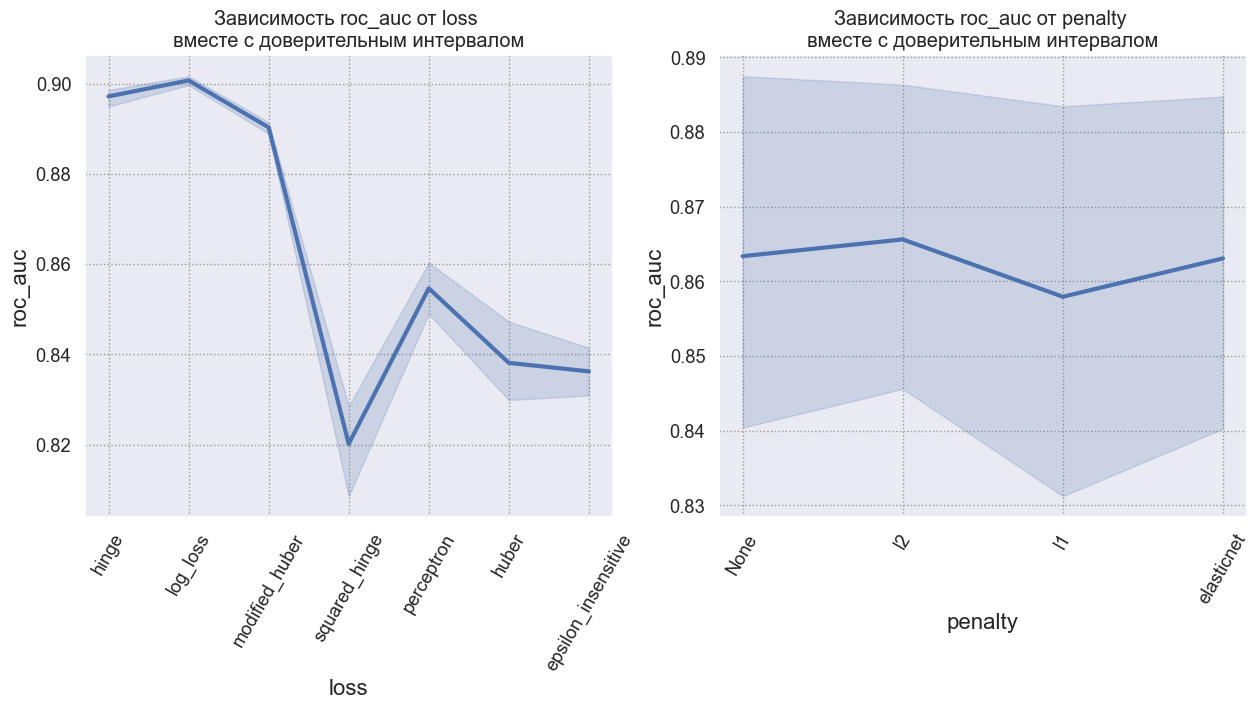

In [122]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 6))

'''
построение графика roc_auc от loss
'''
# построение графиков вместе с 95%-ными доверительными интервалами
sns.lineplot(ax=ax1, data=results_sgd, x="loss", y="mean_auc_score", linewidth=3)
ax1.set(xlabel='loss', ylabel='roc_auc', 
            title='Зависимость roc_auc от loss \nвместе с доверительным интервалом')    
#поворот подписей
ax1.set_xticks(range(len(sgd_parameters['loss'])))
ax1.set_xticklabels(sgd_parameters['loss'], rotation=60)
'''
построение графика roc_auc от penalty
'''
sns.lineplot(ax=ax2, data=results_sgd, x="penalty", y="mean_auc_score", linewidth=3)
ax2.set(xlabel='penalty', ylabel='roc_auc', 
            title='Зависимость roc_auc от penalty \nвместе с доверительным интервалом')    
#поворот подписей
ax2.set_xticks(range(len(sgd_parameters['penalty'])))
ax2.set_xticklabels(['None', 'l2', 'l1', 'elasticnet'], rotation=60)

plt.show()

In [123]:
# оптимальные гиперпараметры
print('Оптимальные гиперпараметры:', gridSearchCV_sgd_clf.best_params_)

# возвращает классификатор с лучшими параметрами
best_gridSearchCV_sgd_clf=gridSearchCV_sgd_clf.best_estimator_  

Оптимальные гиперпараметры: {'loss': 'log_loss', 'penalty': None}


По графикам видно, что для данной задачи лучше всего подходят loss-функции log_loss, hinge и modified_huber, в то время как squared_hinge показывает худшие результаты. Параметр penalty практически никак не влияет на качество модели.

### 5.3 RandomForestClassifier

- Инициализируем дефолтную модель.
- Инициализируем GridSearchCV для подбора гиперпараметров.
- Подберем наилучшие параметры для модели с помощью GridSearchCV.
- Построем график зависимости качества ROC_AUC от параметров (получается 2 графика) с доверительным интервалом. Ось Х - значения параметра, ось Y - значения ROC_AUC.

Подберем оптимальные параметры:
- Число деревьев (**n_estimators**) Перебирать буду в диапазоне от 0 до 100.
- Параметр максимального количества фичей для построения дерева (**max_features**) Перебираю из \['auto', 'sqrt', 'log2', None\]
- Критерий разбиения на поддеревья (**criterion**). Выбор из \['gini', 'entropy'\].

Сохраним модель с оптимальными гиперпараметрами.

Если производить перебор "в лоб", то это займет ооочень много времени. Поэтому сначала отдельно перебирать буду число деревьев
(**n_estimators**). Перебор буду производить до тех пор, пока качество модели не стабилизируется. Этот процесс проведу двумя способами:

_Способ 1_
1. Разбивка выборки на обучающую и тестовую с помощью train_test_split.
2. Для каждого числа деревьев производится:
  - Обучение модель на обучающей выборке
  - Расчет скор на тестовой выборке и последующее его сохранение
3. График зависимости качества предсказания модели от числа деревьев.
4. Выбор оптимального количества деревьев.

_Способ 2_
1. Для каждого числа деревьев: Расчет скор, используя cross_val_score и последующее его сохранение
2. График зависимости качества предсказания модели от числа деревьев.
3. Выбор оптимального количества деревьев.

В дальнейших экспериментах буду ичпользовать подобранное количество деревьев.

### Подбор оптимального количества деревьев

#### Способ 1

In [124]:
max_trees_number = 100
result_method1 = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

for current_trees_number in range(1, max_trees_number):
    RFC_model = RandomForestClassifier(n_estimators=current_trees_number)
    RFC_model.fit(X_train, y_train)
    roc_auc = roc_auc_score(y_test, RFC_model.predict_proba(X_test)[:, 1])
    result_method1.append(roc_auc)

#### Способ 2

In [125]:
max_trees_number = 100
result_method2 = []

for current_trees_number in range(1, max_trees_number):
    RFC_model = RandomForestClassifier(n_estimators=current_trees_number)
    roc_auc = cross_val_score(RFC_model, X, y, cv=5, scoring='roc_auc')
    result_method2.append(roc_auc.mean())

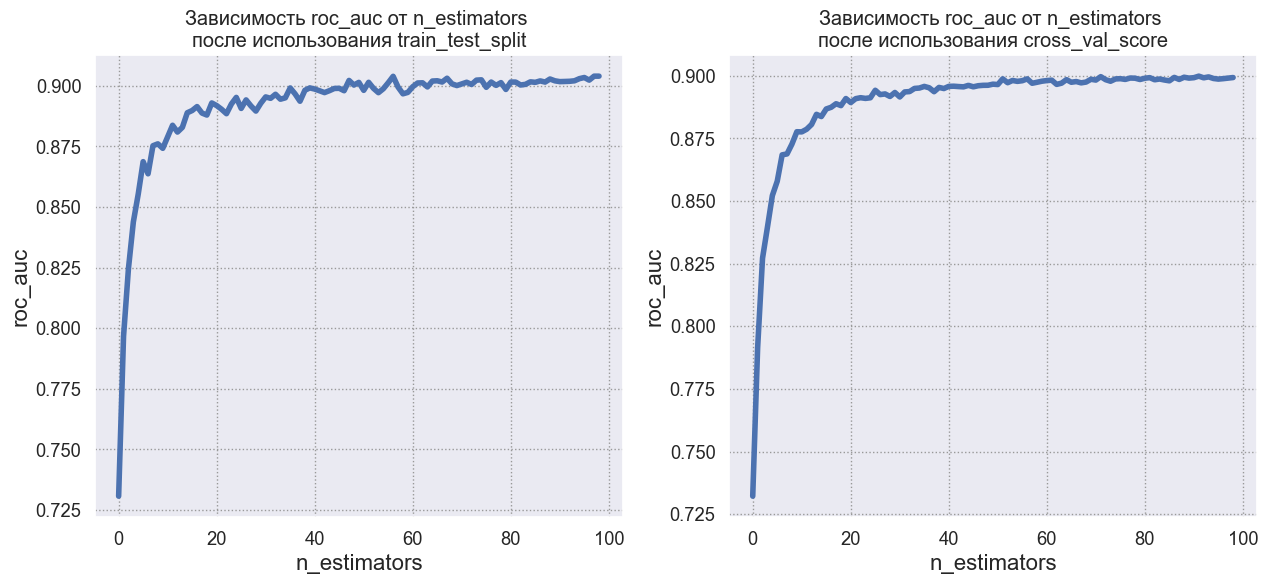

In [126]:
'''посмотрим на графики зависимости auc_score от числа деревьев'''
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sns.lineplot(ax=ax1, data=result_method1, linewidth=4)
ax1.set(xlabel='n_estimators', ylabel='roc_auc', 
            title='Зависимость roc_auc от n_estimators \nпосле использования train_test_split')    

sns.lineplot(ax=ax2, data=result_method2, linewidth=4)
ax2.set(xlabel='n_estimators', ylabel='roc_auc', 
            title='Зависимость roc_auc от n_estimators \nпосле использования cross_val_score')    
plt.show()

Из графиков обнаруживаем, что при малом значении n_estimators с увеличением числа деревьев значение roc_auc очень быстро увеличивается. Однако, начиная с 20 деревьев рост значения метрики замедляется и после n_estimators = 80 изменений практически не наблюдается. Лучше ориентироваться на правый график, т.к. там происходила кросс-валидация, а затем было усреднение результатов (именно поэтому на правом графике скачки/колебания меньше). Так как после n_estimators = 80 начинаются колебания около roc_auc = 0.9, то увеличивать число деревьев в лесу не имеет смысла. Поэтому в дальнейших экспериментах буду использовать n_estimators = 80.

In [127]:
rf_model = RandomForestClassifier(n_estimators=80, n_jobs=-1)

# пространство гиперпараметров
rf_parameters={'criterion':  ['gini', 'entropy'], 'max_features':  ['auto', 'sqrt', 'log2', None]}

gridSearchCV_rf_clf = GridSearchCV(estimator=rf_model, param_grid=rf_parameters, cv=skf, scoring='roc_auc', verbose=3) 
# здесь skf - stratifiedKFolds кросс-валидатор с 5 фолдами (ранее был инициализирован)

In [128]:
gridSearchCV_rf_clf.fit(X, y) # обучение

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .criterion=gini, max_features=auto;, score=0.902 total time=   2.2s
[CV 2/5] END .criterion=gini, max_features=auto;, score=0.901 total time=   0.5s
[CV 3/5] END .criterion=gini, max_features=auto;, score=0.897 total time=   0.5s
[CV 4/5] END .criterion=gini, max_features=auto;, score=0.907 total time=   0.5s
[CV 5/5] END .criterion=gini, max_features=auto;, score=0.890 total time=   0.5s
[CV 1/5] END .criterion=gini, max_features=sqrt;, score=0.901 total time=   0.5s
[CV 2/5] END .criterion=gini, max_features=sqrt;, score=0.900 total time=   0.5s
[CV 3/5] END .criterion=gini, max_features=sqrt;, score=0.897 total time=   0.5s
[CV 4/5] END .criterion=gini, max_features=sqrt;, score=0.907 total time=   0.5s
[CV 5/5] END .criterion=gini, max_features=sqrt;, score=0.888 total time=   0.5s
[CV 1/5] END .criterion=gini, max_features=log2;, score=0.901 total time=   0.5s
[CV 2/5] END .criterion=gini, max_features=log2;,

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=RandomForestClassifier(n_estimators=80, n_jobs=-1),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 'sqrt', 'log2', None]},
             scoring='roc_auc', verbose=3)

In [129]:
# все результаты обучения модели
all_results_rf = gridSearchCV_rf_clf.cv_results_

'''
занесем в таблицу results_rf результаты обучения модели: среднее значение roc_auc и значения гиперпараметров
'''
results_rf = pd.DataFrame()
results_rf['mean_auc_score'] = all_results_rf['mean_test_score']      # среднее значение roc_auc_score

# значения гиперпараметров
results_rf['params'] = all_results_rf['params']
results_rf['criterion'] = results_rf['params'].apply(lambda x: x.get('criterion'))
results_rf['max_features'] = results_rf['params'].apply(lambda x: x.get('max_features'))
results_rf.drop(['params'], axis=1, inplace=True)
results_rf = results_rf.fillna('None')
results_rf.sort_values('mean_auc_score', ascending=False).head()

,mean_auc_score,criterion,max_features
7,0.902169,entropy,None
5,0.899982,entropy,sqrt
3,0.899945,gini,None
4,0.899871,entropy,auto
0,0.899359,gini,auto


### Графики

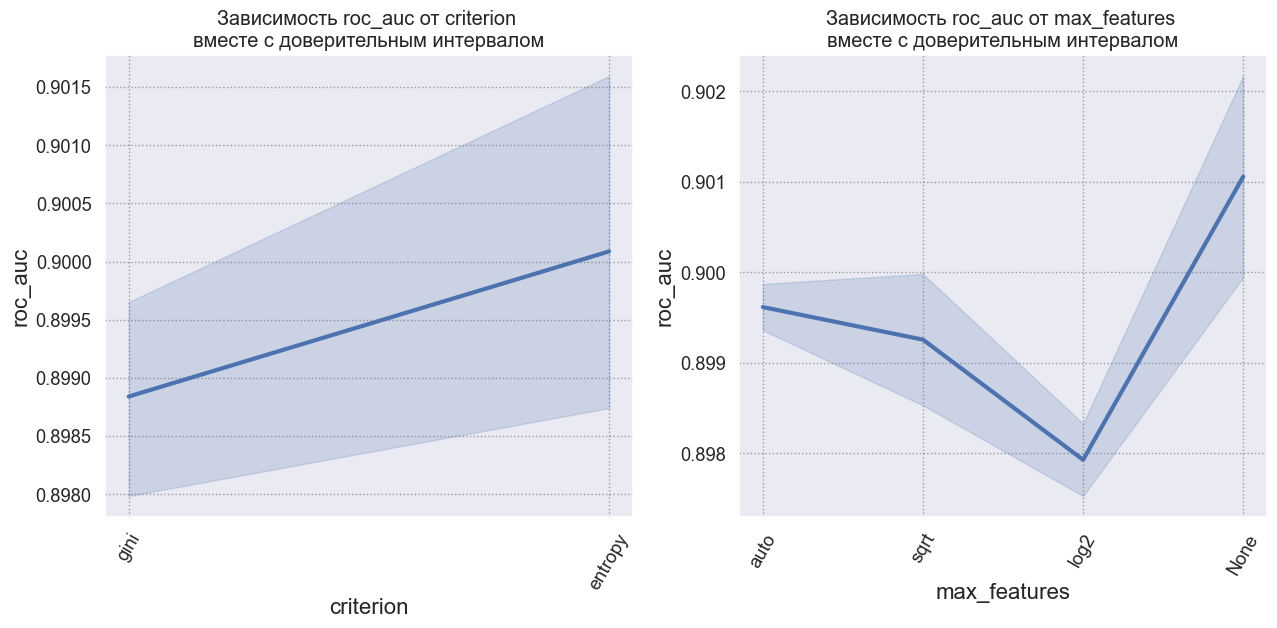

In [130]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 6))

'''
построение графика roc_auc от criterion
'''
# построение графиков вместе с 95%-ными доверительными интервалами
sns.lineplot(ax=ax1, data=results_rf, x="criterion", y="mean_auc_score", linewidth=3)
ax1.set(xlabel='criterion', ylabel='roc_auc', 
            title='Зависимость roc_auc от criterion \nвместе с доверительным интервалом')    
#поворот подписей
ax1.set_xticks(range(len(rf_parameters['criterion'])))
ax1.set_xticklabels(rf_parameters['criterion'], rotation=60)
'''
построение графика roc_auc от penalty
'''
sns.lineplot(ax=ax2, data=results_rf, x="max_features", y="mean_auc_score", linewidth=3)
ax2.set(xlabel='max_features', ylabel='roc_auc', 
            title='Зависимость roc_auc от max_features \nвместе с доверительным интервалом')    
#поворот подписей
ax2.set_xticks(range(len(rf_parameters['max_features'])))
ax2.set_xticklabels(['auto', 'sqrt', 'log2', 'None'], rotation=60)

plt.show()

Видим, что с критерием разбиения на поддеревья entropy качество модели в среднем чуть лучше, но в то же время побольше дисперсия. К тому же интересно отметить, что лучшее значение метрики достигается, если совсем не фиксировать максимальное количество фичей для построения дерева.

In [131]:
# оптимальные гиперпараметры
print('Оптимальные гиперпараметры:', gridSearchCV_rf_clf.best_params_)

# возвращает классификатор с лучшими параметрами
best_gridSearchCV_rf_clf=gridSearchCV_rf_clf.best_estimator_  

Оптимальные гиперпараметры: {'criterion': 'entropy', 'max_features': None}


## 6. Ансамбль моделей

Попробуем "заблендить" модели (сложить результаты (ответы) разных алгоритмов) с разными коэффициентами перед ними.

А именно попробуем различные комбинации алгоритмов. А так же все три алгоритма вместе.

$$result(x) = clf_1(x) * \alpha + clf_2(x) * (1 - \alpha)$$

Подробнее про ансамбли: [здесь](https://dyakonov.org/2017/03/10/cтекинг-stacking-и-блендинг-blending/)

Простой пример использования VotingClassifier и его описание можно найти в официальной документации: [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html) 


In [132]:
# еще раз лучшие модели
best_knn = gridSearchCV_knn_clf.best_estimator_ 
best_sgd = gridSearchCV_sgd_clf.best_estimator_ 
best_rf = gridSearchCV_rf_clf.best_estimator_ 

# комбинации
vc_knn_sgd = VotingClassifier([('knn', best_knn), ('sgd', best_sgd)], voting='soft')
vc_knn_rf = VotingClassifier([('knn', best_knn), ('rf', best_rf)], voting='soft')
vc_sgd_rf = VotingClassifier([('sgd', best_sgd), ('rf', best_rf)], voting='soft')
vc_all = VotingClassifier([('knn', best_knn), ('sgd', best_sgd), ('rf', best_rf)], voting='soft')

# пространство гиперпараметров
vc_pair_params = {'weights': [[i, 1 - i] for i in np.arange(0, 1.05, 0.1)]}
vc_all_params = {'weights': [[i, j, 1 - i - j] for i in np.arange(0, 1.1, 0.1) for j in np.arange(0, 1.05 - i, 0.1)]}


In [133]:
# Обучение комбинаций из двух
grid_vc_knn_sgd_clf = GridSearchCV(estimator=vc_knn_sgd, param_grid=vc_pair_params, cv=skf, scoring='roc_auc', verbose=3)
grid_vc_knn_sgd_clf.fit(X, y) 

grid_vc_knn_rf_clf = GridSearchCV(estimator=vc_knn_rf, param_grid=vc_pair_params, cv=skf, scoring='roc_auc', verbose=3)
grid_vc_knn_rf_clf.fit(X, y) 

grid_vc_sgd_rf_clf = GridSearchCV(estimator=vc_sgd_rf, param_grid=vc_pair_params, cv=skf, scoring='roc_auc', verbose=3)
grid_vc_sgd_rf_clf.fit(X, y) 

# Обучение комбинации из всех трех
grid_vc_all_clf = GridSearchCV(estimator=vc_all, param_grid=vc_all_params, cv=skf, scoring='roc_auc', verbose=3)
grid_vc_all_clf.fit(X, y) 

Fitting 5 folds for each of 11 candidates, totalling 55 fits
[CV 1/5] END ................weights=[0.0, 1.0];, score=0.907 total time=   0.2s
[CV 2/5] END ................weights=[0.0, 1.0];, score=0.902 total time=   0.2s
[CV 3/5] END ................weights=[0.0, 1.0];, score=0.902 total time=   0.2s
[CV 4/5] END ................weights=[0.0, 1.0];, score=0.909 total time=   0.2s
[CV 5/5] END ................weights=[0.0, 1.0];, score=0.886 total time=   0.2s
[CV 1/5] END ................weights=[0.1, 0.9];, score=0.907 total time=   0.2s
[CV 2/5] END ................weights=[0.1, 0.9];, score=0.904 total time=   0.2s
[CV 3/5] END ................weights=[0.1, 0.9];, score=0.902 total time=   0.2s
[CV 4/5] END ................weights=[0.1, 0.9];, score=0.907 total time=   0.2s
[CV 5/5] END ................weights=[0.1, 0.9];, score=0.893 total time=   0.2s
[CV 1/5] END ................weights=[0.2, 0.8];, score=0.909 total time=   0.2s
[CV 2/5] END ................weights=[0.2, 0.8];

[CV 3/5] END weights=[0.8, 0.19999999999999996];, score=0.903 total time=   1.5s
[CV 4/5] END weights=[0.8, 0.19999999999999996];, score=0.909 total time=   1.5s
[CV 5/5] END weights=[0.8, 0.19999999999999996];, score=0.890 total time=   1.6s
[CV 1/5] END weights=[0.9, 0.09999999999999998];, score=0.902 total time=   1.5s
[CV 2/5] END weights=[0.9, 0.09999999999999998];, score=0.896 total time=   1.5s
[CV 3/5] END weights=[0.9, 0.09999999999999998];, score=0.898 total time=   1.5s
[CV 4/5] END weights=[0.9, 0.09999999999999998];, score=0.905 total time=   1.5s
[CV 5/5] END weights=[0.9, 0.09999999999999998];, score=0.887 total time=   1.5s
[CV 1/5] END ................weights=[1.0, 0.0];, score=0.897 total time=   1.5s
[CV 2/5] END ................weights=[1.0, 0.0];, score=0.889 total time=   1.5s
[CV 3/5] END ................weights=[1.0, 0.0];, score=0.892 total time=   1.5s
[CV 4/5] END ................weights=[1.0, 0.0];, score=0.900 total time=   1.5s
[CV 5/5] END ...............

[CV 1/5] END weights=[0.0, 0.6000000000000001, 0.3999999999999999];, score=0.913 total time=   1.6s
[CV 2/5] END weights=[0.0, 0.6000000000000001, 0.3999999999999999];, score=0.911 total time=   1.6s
[CV 3/5] END weights=[0.0, 0.6000000000000001, 0.3999999999999999];, score=0.911 total time=   1.6s
[CV 4/5] END weights=[0.0, 0.6000000000000001, 0.3999999999999999];, score=0.917 total time=   1.6s
[CV 5/5] END weights=[0.0, 0.6000000000000001, 0.3999999999999999];, score=0.899 total time=   1.6s
[CV 1/5] END weights=[0.0, 0.7000000000000001, 0.29999999999999993];, score=0.912 total time=   1.6s
[CV 2/5] END weights=[0.0, 0.7000000000000001, 0.29999999999999993];, score=0.912 total time=   1.7s
[CV 3/5] END weights=[0.0, 0.7000000000000001, 0.29999999999999993];, score=0.908 total time=   1.6s
[CV 4/5] END weights=[0.0, 0.7000000000000001, 0.29999999999999993];, score=0.917 total time=   1.6s
[CV 5/5] END weights=[0.0, 0.7000000000000001, 0.29999999999999993];, score=0.897 total time=   

[CV 1/5] END ...........weights=[0.2, 0.4, 0.4];, score=0.914 total time=   1.6s
[CV 2/5] END ...........weights=[0.2, 0.4, 0.4];, score=0.910 total time=   1.5s
[CV 3/5] END ...........weights=[0.2, 0.4, 0.4];, score=0.911 total time=   1.6s
[CV 4/5] END ...........weights=[0.2, 0.4, 0.4];, score=0.917 total time=   1.6s
[CV 5/5] END ...........weights=[0.2, 0.4, 0.4];, score=0.898 total time=   1.5s
[CV 1/5] END weights=[0.2, 0.5, 0.30000000000000004];, score=0.914 total time=   1.5s
[CV 2/5] END weights=[0.2, 0.5, 0.30000000000000004];, score=0.912 total time=   1.6s
[CV 3/5] END weights=[0.2, 0.5, 0.30000000000000004];, score=0.911 total time=   1.5s
[CV 4/5] END weights=[0.2, 0.5, 0.30000000000000004];, score=0.916 total time=   1.5s
[CV 5/5] END weights=[0.2, 0.5, 0.30000000000000004];, score=0.899 total time=   1.5s
[CV 1/5] END weights=[0.2, 0.6000000000000001, 0.19999999999999996];, score=0.912 total time=   1.5s
[CV 2/5] END weights=[0.2, 0.6000000000000001, 0.199999999999999

[CV 2/5] END weights=[0.4, 0.4, 0.19999999999999996];, score=0.910 total time=   1.6s
[CV 3/5] END weights=[0.4, 0.4, 0.19999999999999996];, score=0.910 total time=   1.7s
[CV 4/5] END weights=[0.4, 0.4, 0.19999999999999996];, score=0.914 total time=   1.6s
[CV 5/5] END weights=[0.4, 0.4, 0.19999999999999996];, score=0.898 total time=   1.6s
[CV 1/5] END weights=[0.4, 0.5, 0.09999999999999998];, score=0.910 total time=   1.5s
[CV 2/5] END weights=[0.4, 0.5, 0.09999999999999998];, score=0.908 total time=   1.7s
[CV 3/5] END weights=[0.4, 0.5, 0.09999999999999998];, score=0.907 total time=   1.6s
[CV 4/5] END weights=[0.4, 0.5, 0.09999999999999998];, score=0.914 total time=   1.6s
[CV 5/5] END weights=[0.4, 0.5, 0.09999999999999998];, score=0.896 total time=   1.5s
[CV 1/5] END weights=[0.4, 0.6000000000000001, -1.1102230246251565e-16];, score=0.908 total time=   1.6s
[CV 2/5] END weights=[0.4, 0.6000000000000001, -1.1102230246251565e-16];, score=0.905 total time=   1.6s
[CV 3/5] END wei

[CV 3/5] END weights=[0.7000000000000001, 0.30000000000000004, -1.1102230246251565e-16];, score=0.901 total time=   1.5s
[CV 4/5] END weights=[0.7000000000000001, 0.30000000000000004, -1.1102230246251565e-16];, score=0.908 total time=   1.6s
[CV 5/5] END weights=[0.7000000000000001, 0.30000000000000004, -1.1102230246251565e-16];, score=0.890 total time=   1.6s
[CV 1/5] END weights=[0.8, 0.0, 0.19999999999999996];, score=0.906 total time=   1.6s
[CV 2/5] END weights=[0.8, 0.0, 0.19999999999999996];, score=0.901 total time=   1.6s
[CV 3/5] END weights=[0.8, 0.0, 0.19999999999999996];, score=0.902 total time=   1.6s
[CV 4/5] END weights=[0.8, 0.0, 0.19999999999999996];, score=0.909 total time=   1.6s
[CV 5/5] END weights=[0.8, 0.0, 0.19999999999999996];, score=0.890 total time=   1.6s
[CV 1/5] END weights=[0.8, 0.1, 0.09999999999999995];, score=0.905 total time=   1.6s
[CV 2/5] END weights=[0.8, 0.1, 0.09999999999999995];, score=0.900 total time=   1.6s
[CV 3/5] END weights=[0.8, 0.1, 0.0

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=VotingClassifier(estimators=[('knn',
                                                     KNeighborsClassifier(n_jobs=-1,
                                                                          n_neighbors=46)),
                                                    ('sgd',
                                                     SGDClassifier(loss='log_loss',
                                                                   n_jobs=-1,
                                                                   penalty=None)),
                                                    ('rf',
                                                     RandomForestClassifier(criterion='entropy',
                                                                            max_features=None,
                                                                            n_estimators=80,
                                                                            n_jobs=-1))],
                                        voting='soft'),
             param_grid=...
                                     [0.1, 0.7000000000000001,
                                      0.19999999999999996],
                                     [0.1, 0.8, 0.09999999999999998],
                                     [0.1, 0.9, 0.0], [0.2, 0.0, 0.8],
                                     [0.2, 0.1, 0.7000000000000001],
                                     [0.2, 0.2, 0.6000000000000001],
                                     [0.2, 0.30000000000000004, 0.5],
                                     [0.2, 0.4, 0.4],
                                     [0.2, 0.5, 0.30000000000000004],
                                     [0.2, 0.6000000000000001,
                                      0.19999999999999996],
                                     [0.2, 0.7000000000000001,
                                      0.09999999999999998],
                                     [0.2, 0.8, 0.0], ...]},
             scoring='roc_auc', verbose=3)

In [134]:
knn_sgd_best_score = grid_vc_knn_sgd_clf.best_score_
knn_rf_best_score = grid_vc_knn_rf_clf.best_score_
sgd_rf_best_score = grid_vc_sgd_rf_clf.best_score_
all_best_score = grid_vc_all_clf.best_score_

print('Best scores\n', '-'*50)
print(f'KNN and SGD: {knn_sgd_best_score}')
print(f'KNN and RF: {knn_rf_best_score}')
print(f'SGD and RF: {sgd_rf_best_score}')
print(f'KNN, SGD and RF: {all_best_score}')

Best scores
 --------------------------------------------------
KNN and SGD: 0.904543090022505
KNN and RF: 0.9081759730917254
SGD and RF: 0.9107259403068328
KNN, SGD and RF: 0.9108434630394857


Как и предполагалось, лучшее качество модели наблюдается в случае, когда заблендили все 3 модели.

## 7. Анализ качества моделей

Посмотрим визуально на качество наших моделей.

In [135]:
# уже делал это несколькими ячейками ранее, но еще раз повторю
best_model_knn = KNeighborsClassifier().set_params(**gridSearchCV_knn_clf.best_params_) 
best_model_random_forest = RandomForestClassifier().set_params(**gridSearchCV_rf_clf.best_params_)  
best_model_sgd = SGDClassifier().set_params(**gridSearchCV_sgd_clf.best_params_) 

best_model_voting_classifier = VotingClassifier([('knn', best_knn), ('sgd', best_sgd), ('rf', best_rf)], 
                                                weights=grid_vc_all_clf.best_params_['weights'], voting='soft')

Посмотрим на качество на кросс_валидации:

In [136]:
# В качестве cv попробуем StratifiedKFold с 7 фолдами
skf7 = StratifiedKFold(n_splits = 7, shuffle = True, random_state = 0)

cv_score_knn = cross_val_score(estimator=best_model_knn, X=X, y=y, cv=skf7, scoring='roc_auc')
cv_score_random_forest = cross_val_score(estimator=best_model_random_forest, X=X, y=y, cv=skf7, scoring='roc_auc')
cv_score_sgd = cross_val_score(estimator=best_model_sgd, X=X, y=y, cv=skf7, scoring='roc_auc')
cv_score_voting_classifier = cross_val_score(estimator=best_model_voting_classifier, X=X, y=y, cv=skf7, scoring='roc_auc')

Создам датафрейм с колонками названиями методов (4 колонки), а значения - выход функции cross_val_score

In [137]:
final_result = pd.DataFrame({'KNN': cv_score_knn, 'RF':cv_score_random_forest, 'SGD': cv_score_sgd, 
                             'voting': cv_score_voting_classifier})
final_result

,KNN,RF,SGD,voting
0,0.891845,0.900244,0.903230,0.907191
1,0.897233,0.911668,0.907391,0.917995
2,0.881725,0.896813,0.895109,0.904130
3,0.892952,0.904476,0.898443,0.911777
4,0.908186,0.904717,0.907792,0.916496
5,0.889506,0.901894,0.902211,0.910694
6,0.885352,0.893549,0.885680,0.900699


Построим boxplots

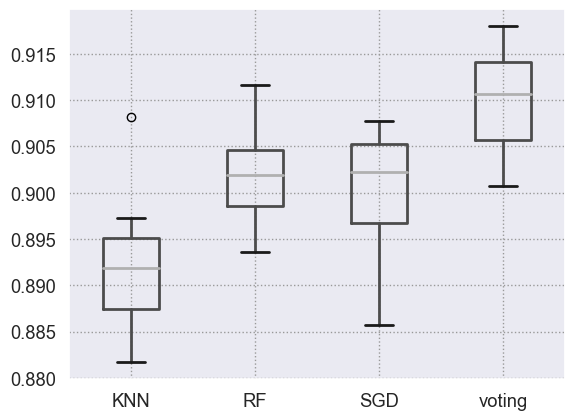

In [138]:
ax = final_result.boxplot() 
_ = plt.setp(ax.lines, linewidth=2.0)
plt.show()

### 8. Выводы

В ходе данного исследования лучших значений roc_auc удалось добиться при использовании ансамбля моделей KNN, SGD и RandomForest. Худший результат продемонстрировал алгоритм K - ближайших соседей; RandomForest и SGD Linear - примерно одинаковое качество.

Если сравнивать между тремя "базовыми" алгоритмами (KNN, RF, SGD), то наиболее стабильный и одновременно качественный результат получается при использовании леса решающих деревьев (в остальных случаях наблюдаются выбросы из boxplot). Однако не стоить забывать, что подбирались всего 2 гиперпараметра, а их на самом деле намного больше (возможно при более тонкой настройке получились бы другие результаты). Что же касается скорости работы, то на этот вопрос ответить немного сложнее: количество ячеек сетки гиперпараметров каждый раз было разным. Если смотреть на время одной итерации обучения, то наиболее быстрый алгоритм - SGD, а наиболее медленный - KNN. Однако при использовании алгоритма RandomForest перебиралось очень мало значений гиперпараметров и несмотря на это удалось достичь высокого качества модели (это говорит о том, что параметры по умолчанию хорошо подходят под решаемую задачу, т.е. без их варьирования получается добиться хорошего результата). 

1. KNN (K-Nearest Neighbors):

- На вход алгоритма подаются обучающая выборка и тестовый объект, который нужно классифицировать.
- Для каждого объекта из обучающей выборки вычисляется расстояние до тестового объекта (например, Евклидово расстояние).
- Выбираются k объектов из обучающей выборки, расстояние до которых наименьшее.
- Класс тестового объекта определяется на основе большинства классов k ближайших соседей.

Преимущества:
- Простота реализации и понимания
- Хорошая производительность на малых наборах данных: алгоритм может обнаруживать сложные нелинейные зависимости между признаками и классами, что делает его полезным инструментом для классификации.
- Не требует обучения, что делает этот алгоритм быстрым в использовании.

Недостатки:
- Как правило, не дает лучшую точность по сравнению с более сложными алгоритмами машинного обучения.
- Требует большого количества памяти, так как необходимо хранить всю обучающую выборку.
- Зависит от выбора числа ближайших соседей и метрики расстояния, что может быть сложным при работе с большими выборками данных или если имеются выбросы.
- Не подходит для работы с данными, которые имеют большое количество признаков, так как он может потерять свою точность и эффективность.

2. SGD (Stochastic Gradient Descent) Linear классификатор:

- Инициализируются веса модели какими-то значениями (обычно случайными)
- Выбирается случайный объект из обучающей выборки.
- Вычисляется ошибка модели на выбранном объекте.
- Коэффициенты модели обновляются на основе градиента ошибки по параметрам модели.
- повторение предыдущих шагов до тех пор, пока не будет достигнуто определенное количество эпох или пока не будет достигнуто некоторое условие остановки.
- Классификация тестового объекта происходит на основе значений весов модели и значений признаков тестового объекта.

Преимущества:
- Эффективность - связано с тем, что алгоритм обновляет параметры модели после каждого примера, что позволяет быстрее сойтись к оптимальной модели.
- Масштабируемость - SGD Linear классификатор может обрабатывать очень большие объемы данных, что делает его полезным для обработки Big Data.
- Относительная простота реализации 
- Хорошее качество классификации для многих задач.

Недостатки:
- Чувствительность к начальным значениям параметров модели, что может привести к неоптимальным результатам.
- Неустойчивость к шуму - алгоритм может давать плохие результаты на данных с высоким уровнем шума.
- Ограниченность модели - SGD Linear классификатор использует линейную модель, что может ограничивать его способность к обработке сложных данных.
- Алгоритм может не сходиться (например, если функция потерь не выпукла)
- Для достижения оптимальной точности требуется тщательная настройка параметров алгоритма.

3. Random Forest классификатор:

Он основан на комбинации множества решающих деревьев, где каждое дерево обучается независимо на случайной подвыборке данных и случайном наборе признаков. Затем результаты всех деревьев объединяются для принятия окончательного решения.

- Выбирается случайная подвыборка данных из общего набора данных.
- Случайным образом выбирается подмножество признаков.
- Обучается дерево решений на выбранной подвыборке данных и подмножестве признаков (в каждом узле дерева происходит разбиение на два поддерева, выбирая признак, который наиболее хорошо разделяет данные на две части). Процесс разбиения продолжается до тех пор, пока не будет достигнут критерий остановки, например, когда в узле остается мало объектов или достигнута максимальная глубина дерева.
- Повторяются предыдущие шаги для каждого дерева. 
- Для каждого объекта из тестовых данных прогнозируется класс каждым деревом. Результаты всех деревьев объединяются для принятия окончательного решения.

Преимущества:

- Высокая точность классификации и регрессии.
- Снижение риска переобучения за счет случайного выбора подмножества признаков и объектов.
- Способность обрабатывать большие объемы данных с большим количеством признаков
- Способность работать с данными, содержащими пропущенные значения и выбросы.

Недостатки:

- Сложность интерпретации результатов.
- Требуется немалое количество деревьев для достижения хорошей точности.
- Требуется большое количество вычислительных ресурсов и времени для обучения и применения.







_____